In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from matplotlib import dates as mdates

In [29]:
# Use the current working directory if DATA_DIR is not set
data_dir = os.environ.get('DATA_DIR', os.getcwd())

csv_files = ['cleaned_twitter_data.csv', 'cleaned_reddit_data.csv', 'cleaned_guardian_df.csv']

dataframes = {}
for file in csv_files:
    path = os.path.join(data_dir, file)
    if os.path.exists(path):
        df_name = file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(path)

DATA ANALYSIS


Comparison of Sentiment Distributions:
           Twitter  Reddit  Guardian
sentiment                           
negative     16.70   37.74     61.34
neutral      72.16   56.36     36.43
positive     11.13    5.90      2.23


<Figure size 1200x800 with 0 Axes>

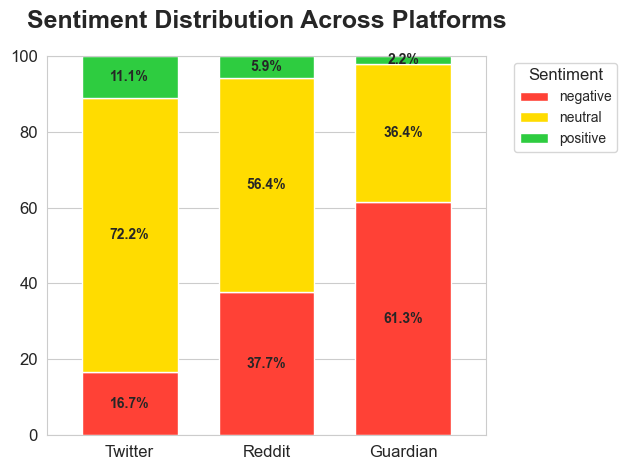

In [30]:


def calculate_sentiment_distribution(df, sentiment_column='sentiment'):
    total = len(df)
    sentiment_counts = df[sentiment_column].value_counts()
    sentiment_percentages = (sentiment_counts / total * 100).round(2)
    return sentiment_percentages.reindex(['negative', 'neutral', 'positive']).fillna(0)

def plot_sentiment_distribution(all_distributions):
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    colors = ['#FF4136', '#FFDC00', '#2ECC40']  # Red, Yellow, Green

    ax = all_distributions.T.plot(kind='bar', stacked=True, width=0.7, color=colors)

    plt.title("Sentiment Distribution Across Platforms", fontsize=18, fontweight='bold', pad=20)
    plt.ylim(0, 100)

    plt.xlabel("")
    plt.ylabel("")

    plt.xticks(rotation=0, ha='center', fontsize=12)
    plt.yticks(fontsize=12)

    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', label_type='center', fontsize=10, fontweight='bold')

    plt.legend(title="Sentiment", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Calculate sentiment distributions
sentiment_distributions = {}
for name, df in dataframes.items():
    try:
        sentiment_distributions[name] = calculate_sentiment_distribution(df)
    except KeyError:
        print(f"Error: 'sentiment' column not found in {name}")

# Create a DataFrame with all distributions
all_distributions = pd.DataFrame(sentiment_distributions)

# Rename the columns to more readable names
column_mapping = {
    'cleaned_twitter_data': 'Twitter',
    'cleaned_reddit_data': 'Reddit',
    'cleaned_guardian_df': 'Guardian'
}
all_distributions = all_distributions.rename(columns=column_mapping)

print("\nComparison of Sentiment Distributions:")
print(all_distributions)

# Plot comparison
plot_sentiment_distribution(all_distributions)


Summary Statistics for Twitter:
             mean  min  max
sentiment                  
negative   172.51   43  280
neutral    139.47   21  280
positive   146.23   67  280

Summary Statistics for Reddit:
             mean  min   max
sentiment                   
negative   276.53   22  7102
neutral    272.52   18  7060
positive    83.88   25   296

Summary Statistics for Guardian:
            mean  min  max
sentiment                 
negative   95.67   47  145
neutral    89.51   45  158
positive   85.33   71   95


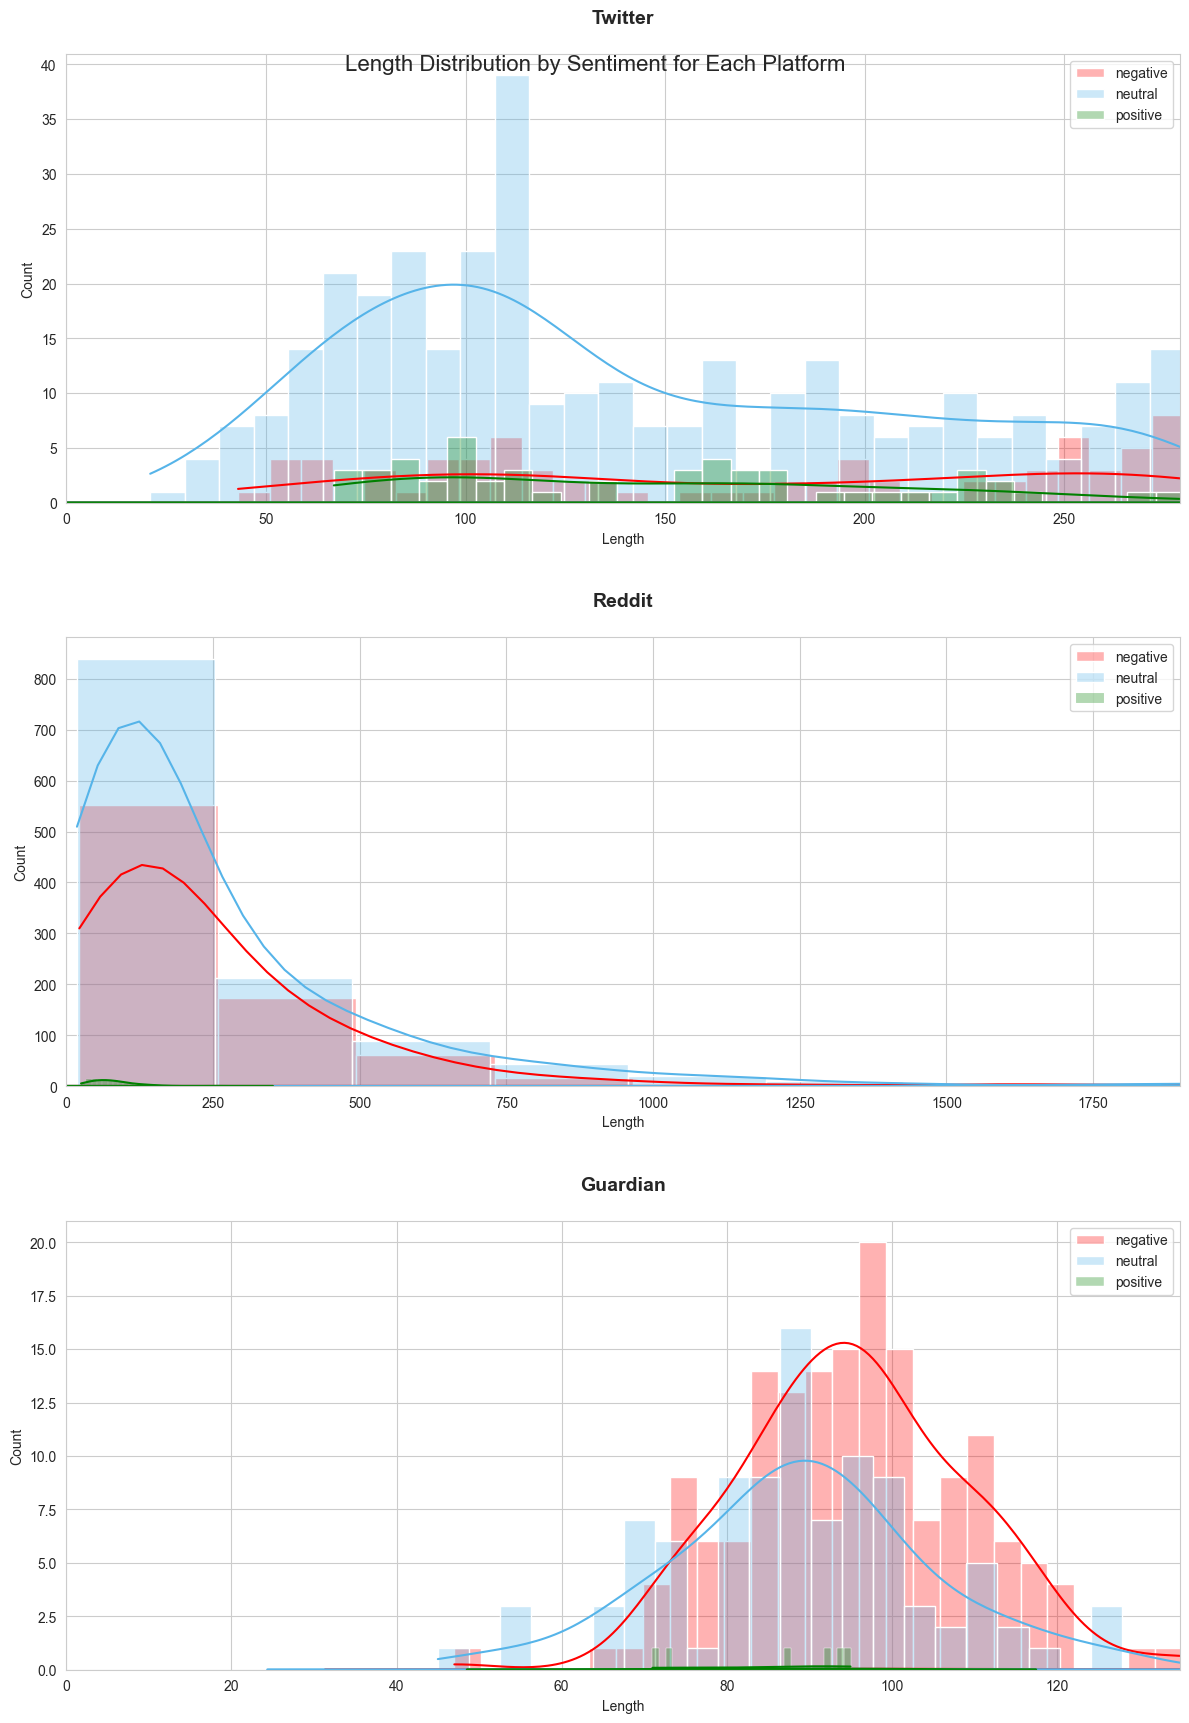

In [32]:
def add_length_column(df, text_column):
    df['length'] = df[text_column].str.len()
    return df

def plot_length_distribution_by_platform(dataframes):
    fig, axes = plt.subplots(len(dataframes), 1, figsize=(12, 6*len(dataframes)))
    fig.suptitle('Length Distribution by Sentiment for Each Platform', fontsize=16, y=0.93)

    colors = {'negative': 'red', 'neutral': '#56B4E9', 'positive': 'green'}

    for i, (name, df) in enumerate(dataframes.items()):
        ax = axes[i] if len(dataframes) > 1 else axes
        
        # Determine the text column
        text_column = 'text' if 'text' in df.columns else 'comment_body' if 'comment_body' in df.columns else None
        if text_column is None:
            print(f"Error: No text column found in {name}")
            continue
        
        # Add length column if not present
        if 'length' not in df.columns:
            df = add_length_column(df, text_column)
        
        for sentiment in ['negative', 'neutral', 'positive']:
            sentiment_data = df[df['sentiment'] == sentiment]
            if not sentiment_data.empty:
                sns.histplot(data=sentiment_data, x='length',
                             ax=ax, label=sentiment, color=colors[sentiment],
                             kde=True, bins=30, alpha=0.3)
                sns.kdeplot(data=sentiment_data, x='length',
                            ax=ax, color=colors[sentiment], linewidth=2)

        platform_name = name.replace('cleaned_', '').replace('_data', '').replace('_df', '').capitalize()
        ax.set_title(platform_name, fontsize=14, fontweight='bold', y=1.05)
        ax.set_xlabel('Length')
        ax.set_ylabel('Count')
        ax.legend()

        # Set x-axis limit to 99th percentile to avoid extreme outliers
        ax.set_xlim(0, df['length'].quantile(0.99))

        # Calculate and print the summary statistics
        stats = df.groupby('sentiment')['length'].agg(['mean', 'min', 'max']).round(2)
        print(f"\nSummary Statistics for {platform_name}:")
        print(stats)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.3)
    plt.show()

# Add length columns to all dataframes
for name, df in dataframes.items():
    text_column = 'text' if 'text' in df.columns else 'comment_body' if 'comment_body' in df.columns else None
    if text_column:
        dataframes[name] = add_length_column(df, text_column)
    else:
        print(f"Warning: No text column found in {name}. Length column not added.")

# Call the function with our dataframes dictionary
plot_length_distribution_by_platform(dataframes)

In [ ]:
pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


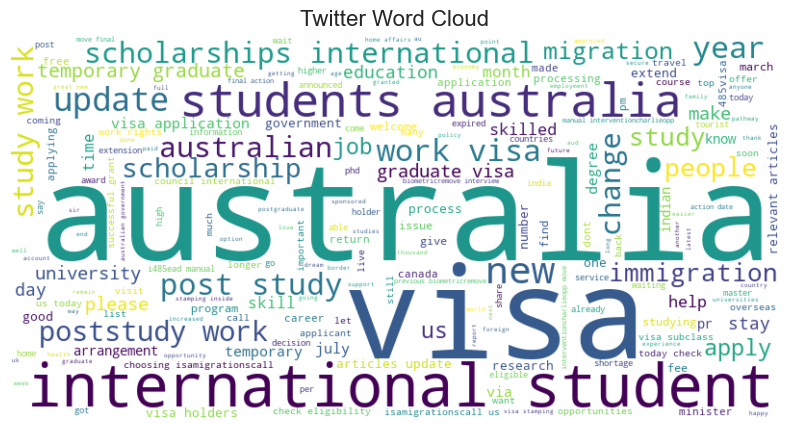

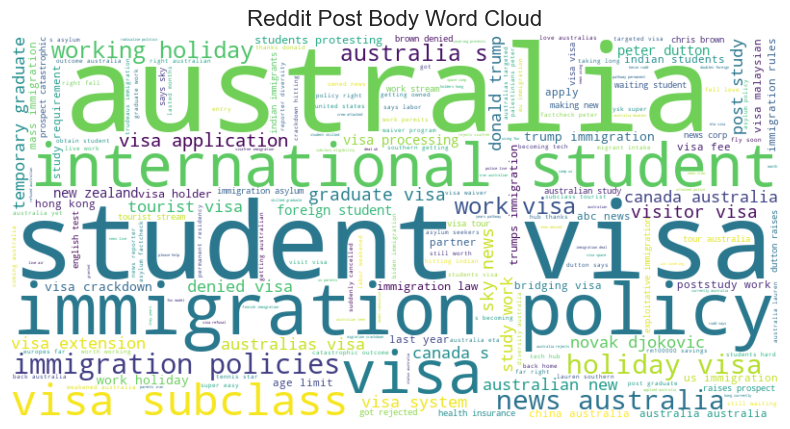

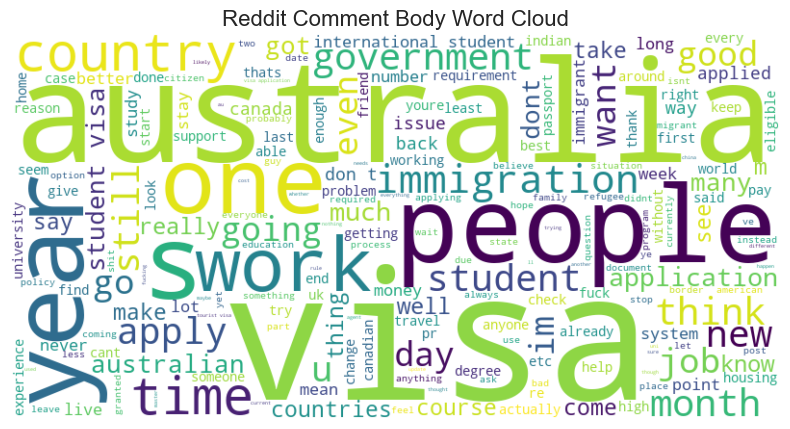

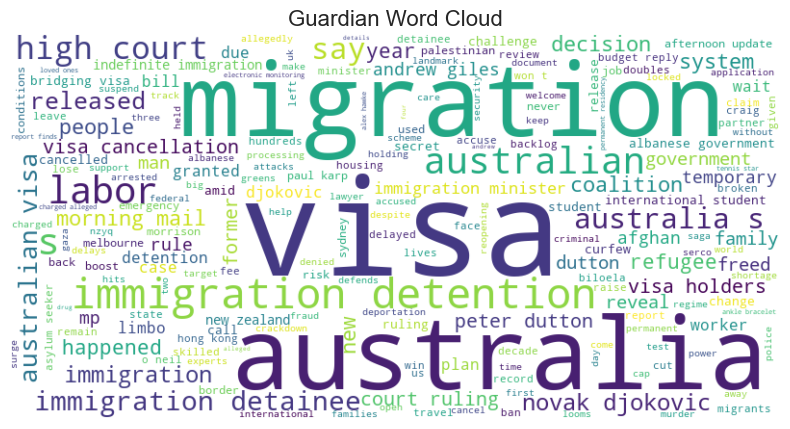

Word cloud generation complete.


In [ ]:
nltk.download('stopwords', quiet=True)

# Get the set of stopwords and add custom words
stop_words = set(stopwords.words('english'))
custom_stopwords = {'will', 'would', 'could', 'should', 'may', 'might', 'must', 'ought', 'need'}
stop_words.update(custom_stopwords)

def clean_text(text):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords and custom words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

def generate_wordcloud(text, title):
    if not text:
        print(f"No text to generate word cloud for: {title}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

def process_and_generate_wordcloud(df, text_column, title):
    # Extract and clean text
    cleaned_text = clean_text(' '.join(df[text_column].dropna().astype(str)))
    # Generate and display word cloud
    generate_wordcloud(cleaned_text, title)

# Process each DataFrame and generate word clouds
for name, df in dataframes.items():
    
    if 'cleaned_twitter_data' in name:
        process_and_generate_wordcloud(df, 'text', 'Twitter Word Cloud')
    elif 'cleaned_reddit_data' in name:
        # Generate word cloud for post bodies
        process_and_generate_wordcloud(df, 'post_body', 'Reddit Post Body Word Cloud')
        # Generate word cloud for comment bodies
        process_and_generate_wordcloud(df, 'comment_body', 'Reddit Comment Body Word Cloud')
    elif 'cleaned_guardian_df' in name:
        process_and_generate_wordcloud(df, 'text', 'Guardian Word Cloud')
    else:
        print(f"Unrecognized dataset: {name}")


print("Word cloud generation complete.")

REDDIT

In [34]:
reddit_df1 = pd.read_csv('cleaned_reddit_data.csv')

In [35]:
import pandas as pd

# Convert the timestamp columns to datetime objects
reddit_df1['post_createdat'] = pd.to_datetime(reddit_df1['post_createdat'])
reddit_df1['comment_createdat'] = pd.to_datetime(reddit_df1['comment_createdat'])

# Calculate the time to first comment for each post
reddit_df1['time_to_first_comment'] = reddit_df1.groupby('post_id')['comment_createdat'].transform('min') - reddit_df1['post_createdat']

# Filter out invalid data (where comment time is earlier than post time)
valid_df = reddit_df1[reddit_df1['time_to_first_comment'] >= pd.Timedelta(0)]

# Calculate the average time to first comment
average_time = valid_df['time_to_first_comment'].mean()

# Format the average time
days = average_time.days
hours, remainder = divmod(average_time.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Average time to first comment: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

# Identify the post with the most comments
post_with_most_comments = valid_df['post_id'].value_counts().idxmax()
most_comments_count = valid_df['post_id'].value_counts().max()

# Retrieve the details of the post with the most comments
post_details = reddit_df1[reddit_df1['post_id'] == post_with_most_comments].iloc[0]

# Create a DataFrame with the specified columns
post_df = pd.DataFrame({
    'id': [post_details['post_id']],
    'post_body': [post_details['post_body']],
    'post_createdat': [post_details['post_createdat']],
    'sentiment': [post_details['sentiment']]
})

print(f"Post with the most comments: {post_with_most_comments} with {most_comments_count} comments")
print("\nPost details:")
print(post_df)

Average time to first comment: 0 days, 13 hours, 55 minutes, 26 seconds
Post with the most comments: gv0e4r with 10 comments

Post details:
       id                                          post_body  \
0  gv0e4r  Australian news crew attacked by police live o...   

                    post_createdat sentiment  
0 2020-06-02 04:22:52.324000+00:00   neutral  


Twitter

In [36]:
import pandas as pd
import ast

# Load the data
df = pd.read_csv('cleaned_twitter_data.csv')

# Function to safely extract user mentions
def extract_mentions(x):
    if pd.isna(x):
        return []
    # Split the string by commas and remove any leading/trailing whitespace
    mentions = [mention.strip() for mention in x.split(',') if mention.strip()]
    # Remove the @ symbol if present
    mentions = [mention[1:] if mention.startswith('@') else mention for mention in mentions]
    return mentions

# Apply the function to extract user mentions
df['user_mentions'] = df['user_mentions'].apply(extract_mentions)

# Flatten the list of user mentions
all_mentions = [mention for mentions in df['user_mentions'] for mention in mentions if mentions]

# Count the occurrences of each user mention
mention_counts = pd.Series(all_mentions).value_counts()

# Get the top 10 most mentioned users
top_10_mentioned = mention_counts.head(10)

print("Top 10 most mentioned users:")
for user, count in top_10_mentioned.items():
    print(f"{user}: {count} mentions")

# If you want to see how many tweets have user mentions
print(f"\nNumber of tweets with user mentions: {df['user_mentions'].apply(len).sum()}")

Top 10 most mentioned users:
AlexHawkeMP: 9 mentions
isamigrationsCall: 8 mentions
ScottMorrisonMP: 8 mentions
SecMayorkas: 7 mentions
AlboMP: 6 mentions
tomwconnell: 5 mentions
POTUS: 5 mentions
VP: 5 mentions
SBSPunjabi: 4 mentions
AlanTudgeMP: 4 mentions

Number of tweets with user mentions: 178


/var/folders/s1/_9n_hw1n0xddhcntyvxyd4h40000gq/T/ipykernel_16194/1330745612.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts['date'] = monthly_counts['date'].dt.to_period('M').dt.to_timestamp()
/var/folders/s1/_9n_hw1n0xddhcntyvxyd4h40000gq/T/ipykernel_16194/1330745612.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts['date'] = monthly_counts['date'].dt.to_period('M').dt.to_timestamp()
/var/folders/s1/_9n_hw1n0xddhcntyvxyd4h40000gq/T/ipykernel_16194/1330745612.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts['date'] = monthly_counts['date'].dt.to_period('M').dt.to_timestamp()


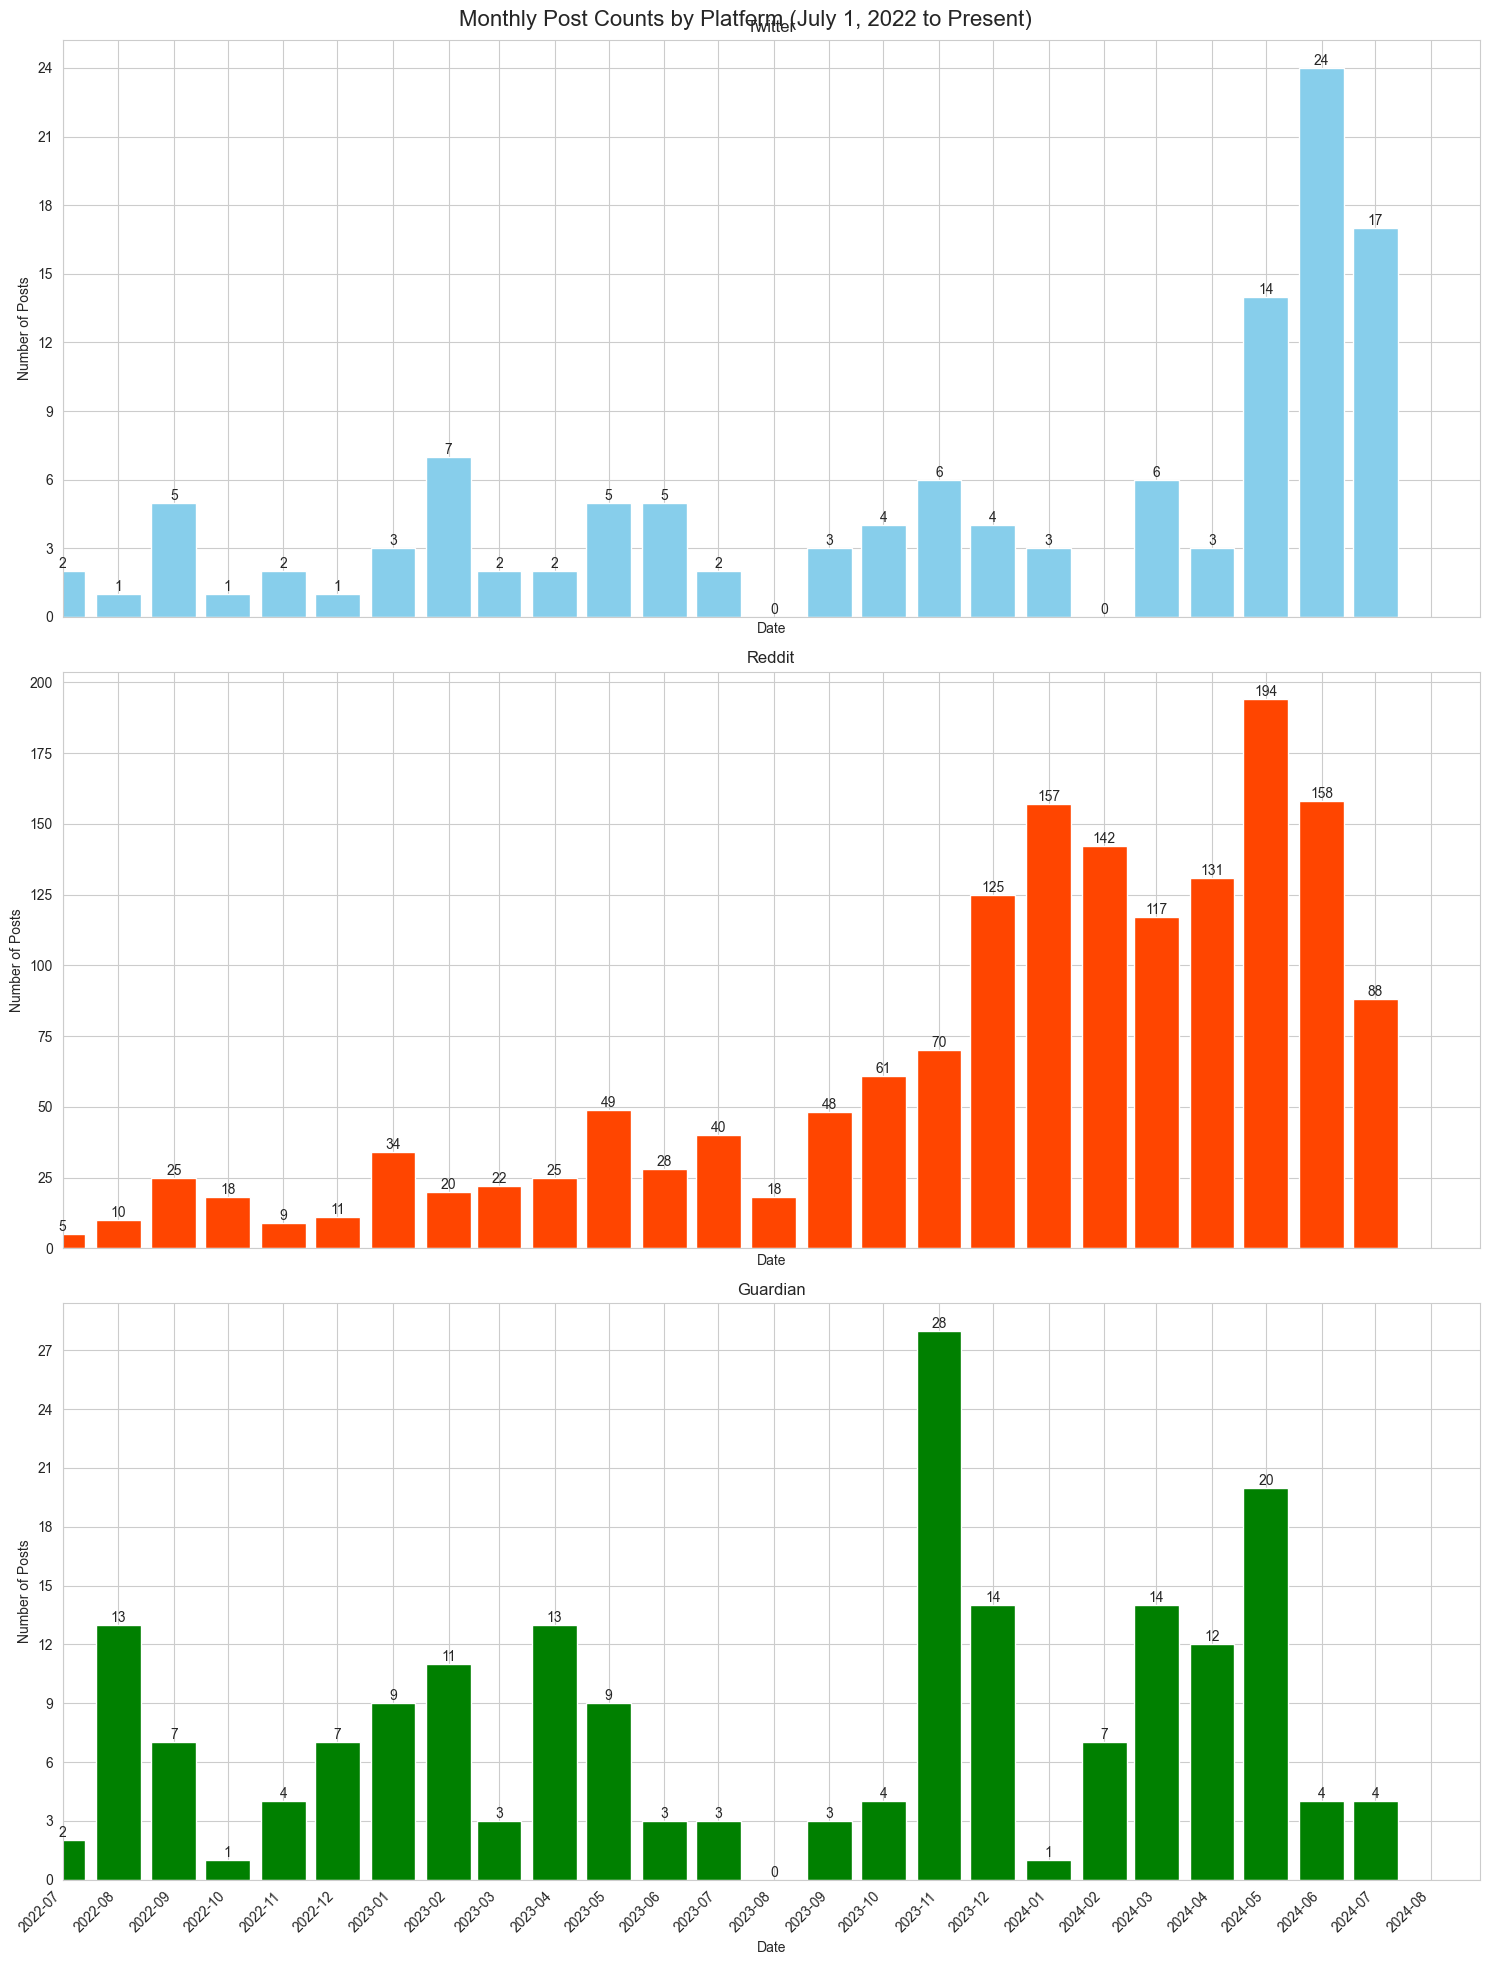

Total posts from 2022-07-01 to 2024-08-28:
Twitter: 122
Reddit: 1605
Guardian: 196


In [41]:
def load_and_process_data(file_path, date_column, platform_name):
    df = pd.read_csv(file_path)
    df[date_column] = pd.to_datetime(df[date_column], utc=True)
    df['platform'] = platform_name
    return df[[date_column, 'platform']].rename(columns={date_column: 'date'})

twitter_df = load_and_process_data('cleaned_twitter_data.csv', 'date', 'Twitter')
reddit_df = load_and_process_data('cleaned_reddit_data.csv', 'post_createdat', 'Reddit')
guardian_df = load_and_process_data('cleaned_guardian_df.csv', 'Publication Date', 'Guardian')

start_date = pd.Timestamp('2022-07-01', tz='UTC')
end_date = pd.Timestamp.now(tz='UTC')

def filter_and_resample_monthly(df, start_date, end_date):
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    monthly_counts = filtered_df.set_index('date').resample('M').size().reset_index(name='count')
    monthly_counts['date'] = monthly_counts['date'].dt.to_period('M').dt.to_timestamp()
    monthly_counts['date_num'] = mdates.date2num(monthly_counts['date'])
    return monthly_counts

twitter_trend = filter_and_resample_monthly(twitter_df, start_date, end_date)
reddit_trend = filter_and_resample_monthly(reddit_df, start_date, end_date)
guardian_trend = filter_and_resample_monthly(guardian_df, start_date, end_date)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
fig.suptitle('Monthly Post Counts by Platform (July 1, 2022 to Present)', fontsize=16)

def plot_monthly_bars(ax, data, color, title):
    ax.bar(data['date_num'], data['count'], color=color, width=25)
    ax.set_title(title)
    ax.set_ylabel('Number of Posts')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    for i, (d, v) in enumerate(zip(data['date_num'], data['count'])):
        ax.text(d, v, str(v), ha='center', va='bottom')

plot_monthly_bars(ax1, twitter_trend, 'skyblue', 'Twitter')
plot_monthly_bars(ax2, reddit_trend, 'orangered', 'Reddit')
plot_monthly_bars(ax3, guardian_trend, 'green', 'Guardian')

# Format x-axis to show correct dates
for ax in (ax1, ax2, ax3):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"Total posts from {start_date.date()} to {end_date.date()}:")
print(f"Twitter: {twitter_trend['count'].sum()}")
print(f"Reddit: {reddit_trend['count'].sum()}")
print(f"Guardian: {guardian_trend['count'].sum()}")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


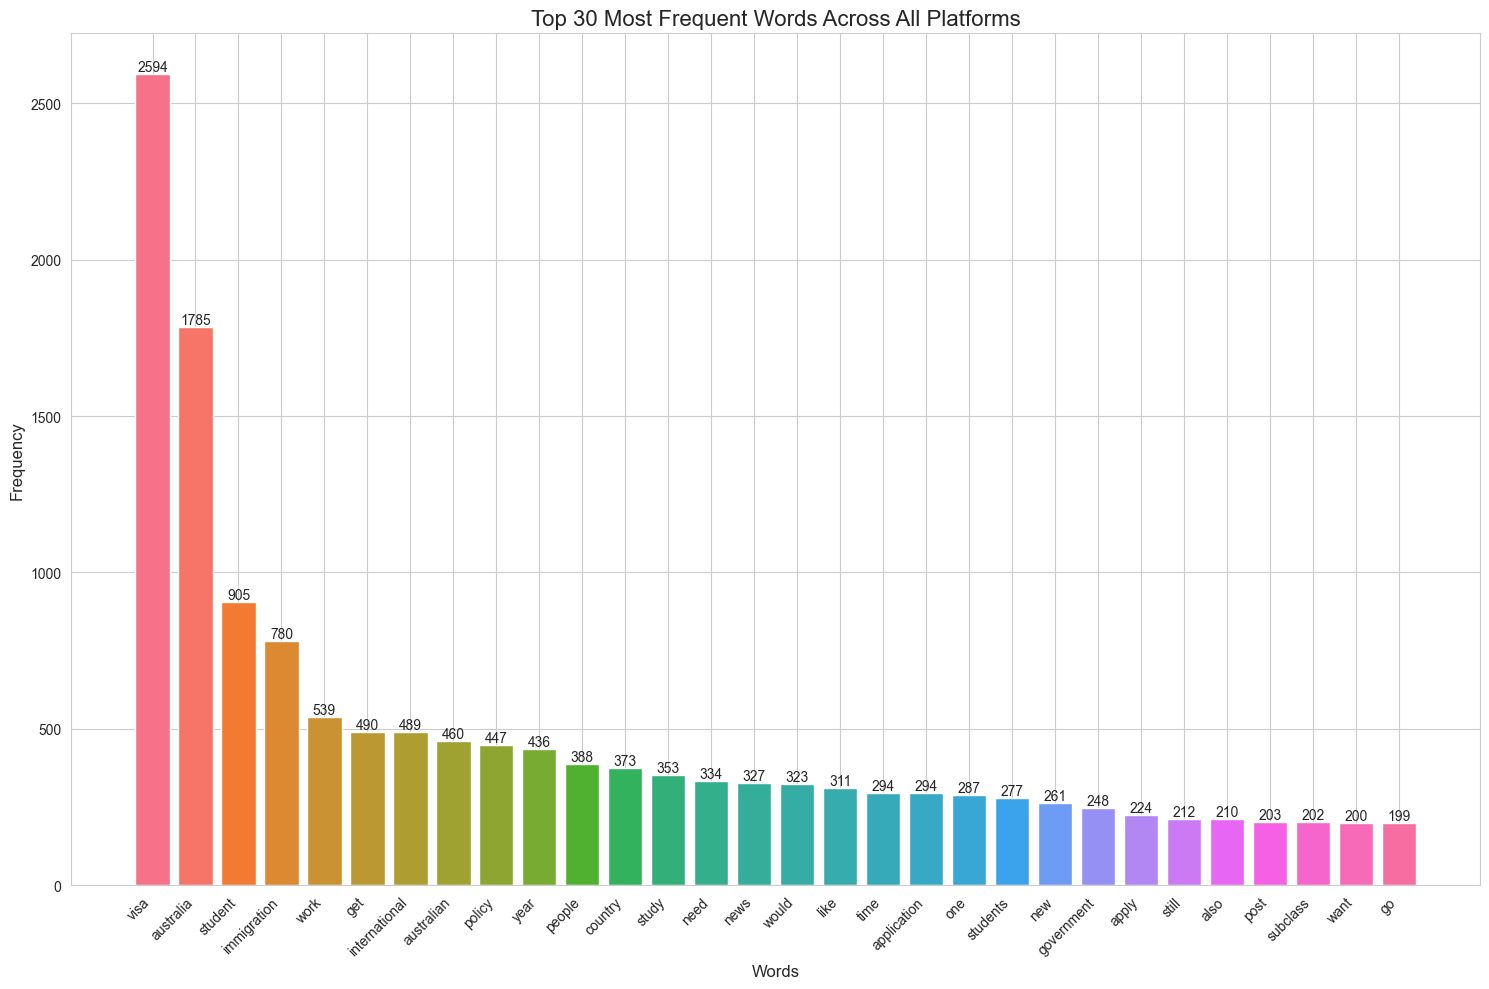

In [53]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from preprocessing import preprocessing  

# Download NLTK stop words and punkt tokenizer
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def load_processed_data(file_path, text_columns):
    df = pd.read_csv(file_path)
    return pd.concat([df[col] for col in text_columns if col in df.columns])

# Load processed Reddit data
reddit_text = load_processed_data('processed_reddit_data.csv', ['processed_post', 'processed_comment'])

# Load and preprocess Twitter data
twitter_df = pd.read_csv('cleaned_twitter_data.csv')
twitter_df['processed_text'] = twitter_df['text'].apply(preprocessing)

# Load and preprocess Guardian data
guardian_df = pd.read_csv('cleaned_guardian_df.csv')
guardian_df['processed_text'] = guardian_df['text'].apply(preprocessing)

# Combine all processed text data
all_text = pd.concat([
    twitter_df['processed_text'], 
    reddit_text, 
    guardian_df['processed_text']
])

# Function to get word frequencies
def get_word_frequencies(text_series):
    all_words = []
    for text in text_series:
        if isinstance(text, str):
            tokens = word_tokenize(text.lower())
            all_words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(all_words)

# Get word frequencies
word_freq = get_word_frequencies(all_text)

# Get top 30 words
top_30_words = word_freq.most_common(30)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(top_30_words, columns=['Word', 'Frequency'])

# Set up the plot style
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create a color palette
colors = sns.color_palette("husl", n_colors=len(df_plot))

# Create the bar chart
bars = plt.bar(df_plot['Word'], df_plot['Frequency'], color=colors)
plt.title('Top 30 Most Frequent Words Across All Platforms', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add frequency labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()